# Mulitvariate Time Series and State Assignment
The dataset in this application is from a temperature sensor on an industrial cooling water flow. 

The data is read on a two second interval, and indexed $0,.., n$ as required by __trcrpm__.

The $3000$ samples are show mostly normal/expected readings from the sensor. Between $1500$ and $2000$ the readings fluctuate rapidly - this fluctuation is due to aging/corroding contacts in the signal path.

The data is split into four separate time series and re-indexed so that the anomaly in the data is in the third time series $d3$. 



The majority of this file is taken from the __trcrpm__ tutorials.  It is included to demonstrate the basic functionality of the code base, as well as to highlight intuitively, the __trcrpm__ algorithm.  

In [8]:
# Import the required python libraries imported
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from trcrpm import TRCRP_Mixture

# Indicates to jupyer how the plots are to be displayed and sized
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [9]:
# Read and inspect the data
data_clean = pd.read_csv("../data/data.csv", index_col=0)
offset = 0
n = 700
# Split, name new columns, and re-index the data
slicing = [ offset, offset + n, offset + 2*n, offset + 3*n, offset + 4*n]
data = pd.concat([data_clean.iloc[slicing[0]:slicing[1],0].reset_index(drop=True), 
                    data_clean.iloc[slicing[1]:slicing[2],0].reset_index(drop=True), 
                    data_clean.iloc[slicing[2]:slicing[3],0].reset_index(drop=True), 
                    data_clean.iloc[slicing[3]:slicing[4],0].reset_index(drop=True)], axis=1
                )
data.columns = [ "d1", "d2", "d3", "d4"]
data.head()

,d1,d2,d3,d4
0,45.605164,45.531920,45.614320,45.522766
1,45.692140,45.596010,45.705870,45.609740
2,45.637207,45.733337,45.724182,45.628050
3,45.600586,45.742493,45.742493,45.655518
4,45.573120,45.710450,45.669250,45.728760


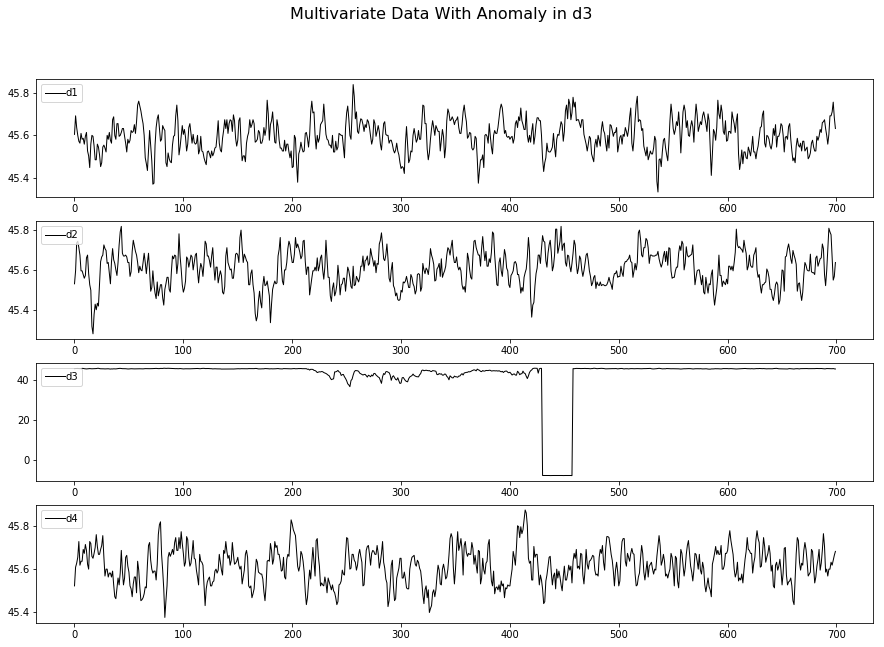

In [10]:
# Plot the data
fig, axes = plt.subplots(nrows=len(data.columns))
fig.suptitle('Multivariate Data With Anomaly in d3', fontsize=16)
for ax, variable in zip(axes, data.columns):
    index = list(data.columns).index(variable)
    x_observed = data.index
    y_observed = data.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    ax.legend(loc='upper left', handletextpad=0)

In [21]:
# Provide entropy ~ number of time series
rng = np.random.RandomState(1)
# Create TRCRP_Mixture model object, with 4 MCMC chaine, and a time dependency over the previous 10 samples
model = TRCRP_Mixture(chains=4, lag=10, variables=data.columns, rng=rng)
# Incorporate the data set into the model
model.incorporate(data)
# Run MCMC inference the latent state for #steps full Gibbs sweeps through all kernels
model.resample_all(steps=10)
# Run empirical Bayes on variable hyperparameters for full Gibbs sweeps through all kernels
model.resample_hyperparameters(steps=10)
# Set up an index/grid, and number of samples desire per index/grid point to run a simulation
probes = model.dataset.index
numsamples = 20
# Generate predictions from the posterior distribution.
samples = model.simulate(probes, model.variables, numsamples)

Completed: 36 iterations in 20.048661 seconds.
Completed: 37 iterations in 20.105945 seconds.
Completed: 30 iterations in 20.202615 seconds.
Completed: 25 iterations in 20.103964 seconds.
Completed: 4 iterations in 11.466590 seconds.
Completed: 5 iterations in 11.747593 seconds.
Completed: 4 iterations in 12.154467 seconds.%
Completed: 5 iterations in 12.729675 seconds.28%


In [25]:
# Helper function to visualize state sequence changes in the model
def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states==state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                alpha=0.3, color=color)

In [26]:
# Helper function to plot model predictions from the posterior
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    # Plot 25--75 percentile bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.fill_between(
        probes,
        np.percentile(samples, 25, axis=0),
        np.percentile(samples, 75, axis=0),
        color='gray',
        alpha=0.5)
    #  Optionally plot latent temporal state at each timepoint,
    #  according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

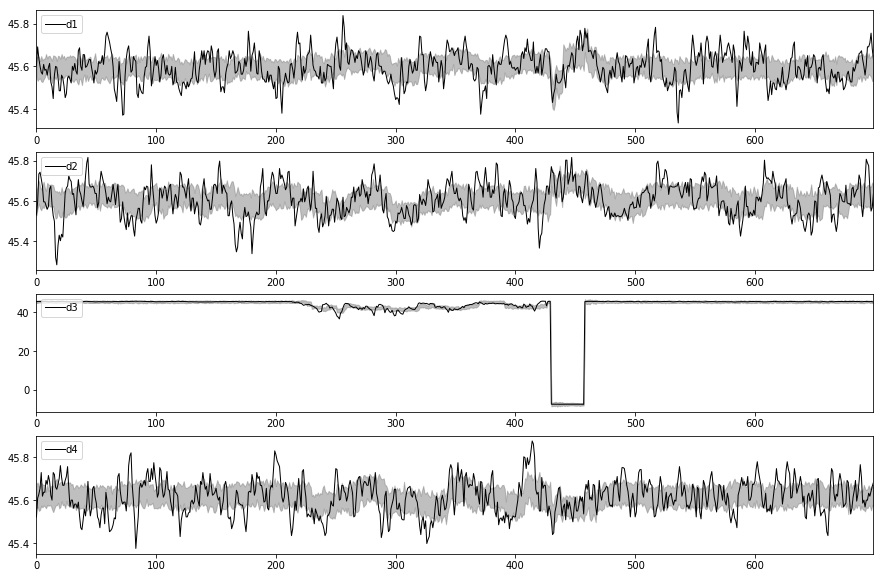

In [27]:
# Plot posterior predictive draws
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(nrows=len(data.columns))
fig.suptitle('Posterior Predictive Draws', fontsize=16)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples, variable, ax)
    ax.set_xlim([min(probes), max(probes)])

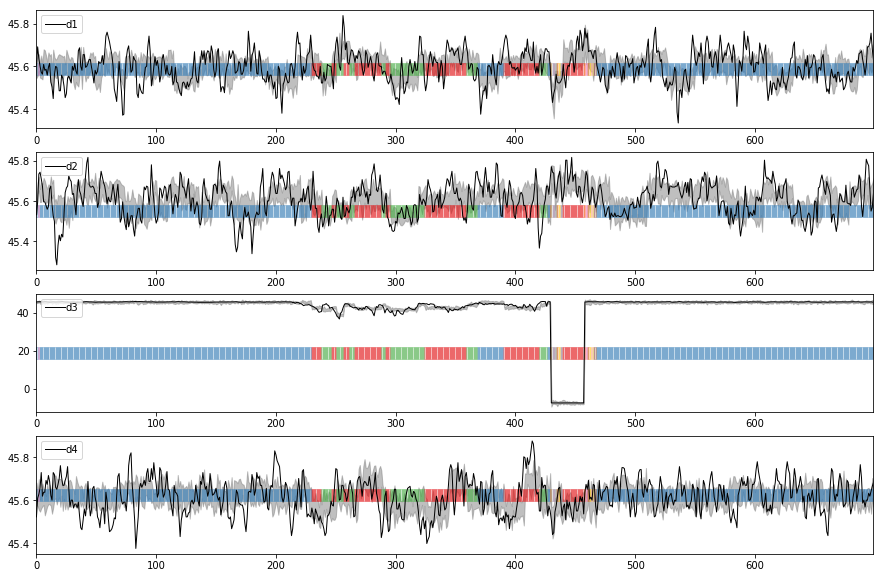

In [28]:
# Plot the model States as they change
chain = 0
samples_chain = samples[numsamples*chain:numsamples*(chain+1)]
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(nrows=4)
fig.suptitle('Model States', fontsize=16)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples_chain, variable, ax, states_from_chain=chain)
    ax.set_xlim([min(probes), max(probes)])

In [29]:
# Generate posterior predictions 100 samples into the future
# Create an index/grid past the end of the current dataset and draw from the posterior
probes = list(model.dataset.index) + range(max(model.dataset.index), max(model.dataset.index)+100)
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

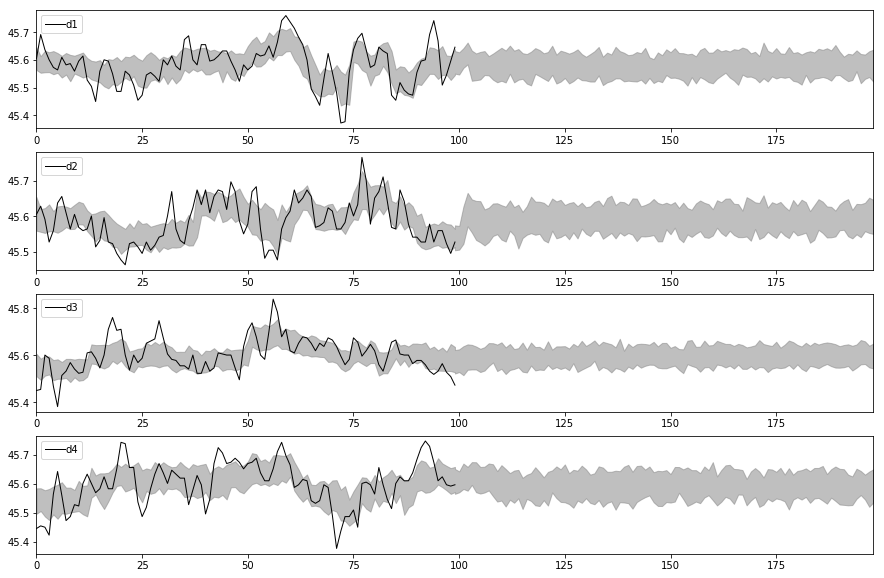

In [14]:
# Plot the predictions
fig, axes = plt.subplots(nrows=4)
fig.suptitle('Posterior Predictive Draws Forward in Time', fontsize=16)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples, variable, ax)
    ax.set_xlim([min(probes), max(probes)])